# Baby Cry Classification using Machine Learning Algorithms

**Author**: Jing Chen

## Project Overview - purpose and our solution

**Project Goal**: In the first phase of our research, we aim to classify baby cry based on demographic features of babies and the acoustic cry signals using machine learning techniques and then compare the performance of the different machine learning methods based on the F1 Score metric.

**Inputs**:
*   Audio files in .wav format including file name
*   Acoustic features extracted from audio waves of baby cries, such as Mel-frequency cepstral coefficients and chroma features
*   Demographic features of babies such as age and gender









**Outputs**: Labels of cry reasons:
*   belly pain
*   burping
*   discomfort
*   hunger
*   tiredness












### Structure of Code

        I. Install and Import Packages

        II. Load Dataset- audio files

        III. Exploratory Data Analysis

        IV. Pre-processing and Feature Extraction

        V. Build Classifier

        VI. Run all models and Report Performance

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 25.7 MB/s eta 0:00:00


In [ ]:
# Please change the file path to where you have the input data saved.
project_path = "/content/gdrive/MyDrive/DS5500_Data/"

## I. Install and Import packages

In [ ]:
# load required packages
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
import wave
import pandas as pd
import numpy as np
import pydub
from scipy.io.wavfile import read
from pydub import AudioSegment
from pydub.utils import make_chunks
from os import walk
from os import listdir
from os.path import isfile, join
import random
import seaborn as sns
%matplotlib inline
from statistics import mean
from matplotlib import pyplot, cm
from sklearn.model_selection import train_test_split,cross_validate,RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,GridSearchCV, StratifiedKFold
import sklearn
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy.linalg import eigh
from sklearn.svm import SVC
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Layer, Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Embedding, Input, LayerNormalization, MultiHeadAttention
from keras.layers import MultiHeadAttention as MHA
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from PIL import Image
from IPython.display import display
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW
from tqdm.auto import tqdm

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## II. Load Dataset- audio files

We use Donate-A-Cry corpus dataset, which consists of 457 unique child cry audio files along with tags for babies’ demographic information (age and gender) and cry reasons (such as hungry, belly pain, discomfort, burping, and tiredness).

In [ ]:
# mount google drive to access files and folders
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# create a data frame that contains all file path of audio files and associated label for cry reason
dic_path = os.getcwd()
sub_folder_name = ["belly_pain","burping","discomfort","hungry","tired"]
file_path_df = pd.DataFrame(columns=['file_name','audio_type'])
for t in sub_folder_name:
    wav_files = [project_path+"audio/"+t+"/"+ f for f in os.listdir(project_path+"audio/"+t) if f.endswith(".wav")]
    temp_df = pd.DataFrame({ "file_name" : wav_files, "audio_type" : t})
    file_path_df = pd.concat([file_path_df, temp_df], ignore_index=True)

## III. Exploratory Data Analysis

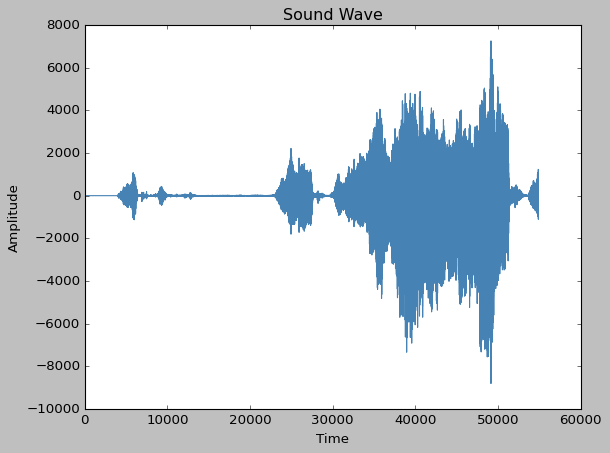

In [ ]:
# visualize one sample audio wave
input_data = read(file_path_df["file_name"][1])
audio_sample = input_data[1]
plt.style.use('classic')
plt.plot(audio_sample, color = "steelblue")
plt.title("Sound Wave")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

In [ ]:
# extract length of file, age and gender of babies from the files and append to the dataframe

def calculate_audio_length(file_path):
    # load audio file using file path and calculate the length of audio in minutes
    y,sr = librosa.load(file_path)
    length = len(y)/sr
    return length

def extract_gender(file_path):
    # extract information on gender from file name
    g = file_path.split("-")[-3]
    if g == "m":
        return "Male"
    else: return "Female"

def extract_age(file_path):
    # extract information on age in month from file name
    a = int(file_path.split("-")[-2])
    return a

In [ ]:
# Extract the demographic information from the audio file names
file_path_df["length"] = file_path_df["file_name"].map(lambda x:calculate_audio_length(x))
file_path_df["gender"] = file_path_df["file_name"].map(lambda x:extract_gender(x))
file_path_df["age_in_months"] = file_path_df["file_name"].map(lambda x:extract_age(x))

In [ ]:
# Check to see if the file has loaded correctly
file_path_df.head(6)

,file_name,audio_type,length,gender,age_in_months
0,/content/gdrive/MyDrive/DS5500_Data/audio/bell...,belly_pain,6.84,Male,4
1,/content/gdrive/MyDrive/DS5500_Data/audio/bell...,belly_pain,6.86,Male,48
2,/content/gdrive/MyDrive/DS5500_Data/audio/bell...,belly_pain,7.00,Male,72
3,/content/gdrive/MyDrive/DS5500_Data/audio/bell...,belly_pain,7.00,Male,72
4,/content/gdrive/MyDrive/DS5500_Data/audio/bell...,belly_pain,7.00,Male,72
5,/content/gdrive/MyDrive/DS5500_Data/audio/bell...,belly_pain,7.00,Male,72


### Gender

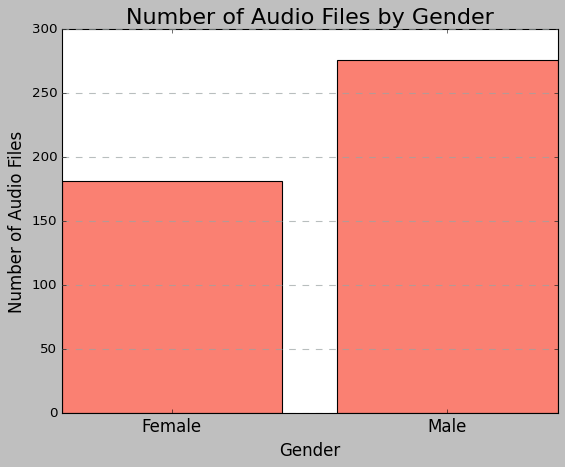

In [ ]:
count_by_gender = pd.DataFrame(file_path_df.groupby(['gender']).size()).rename(columns={0: "count"})
count_by_gender.reset_index(inplace=True)
plt.bar(count_by_gender['gender'], count_by_gender['count'],color = "salmon")
plt.grid(color='#9ba3a3', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.xlabel('Gender', fontsize = 15)
plt.ylabel('Number of Audio Files', fontsize = 15)
plt.title('Number of Audio Files by Gender', fontsize = 20)
plt.xticks(fontsize = 15)
plt.show()

**Observation:** from the above graph we can tell that we have approx. 100 more audio data for male babies than female.

### Age

In [ ]:
# Get the statistics on age of babies
file_path_df['age_in_months'].apply(["max","median","min"])

max       72.0
median    26.0
min        4.0
Name: age_in_months, dtype: float64

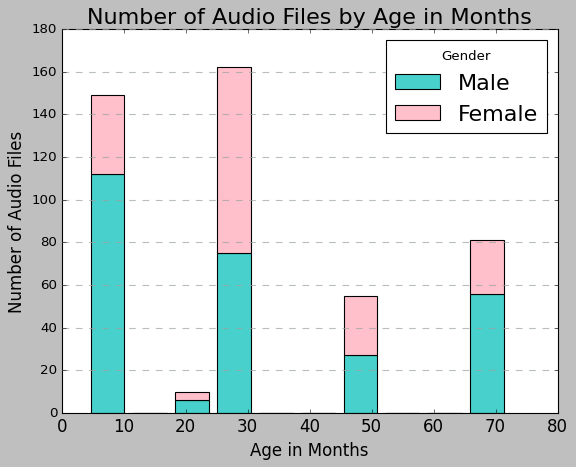

In [ ]:
# Create list of data according to different gender
x1 = list(file_path_df[file_path_df['gender'] == "Male"]['age_in_months'])
x2 = list(file_path_df[file_path_df['gender'] == "Female"]['age_in_months'])

colors=['mediumturquoise', 'pink']
names=['Male', 'Female']

plt.hist([x1, x2], color=colors, label=names, stacked = True)
plt.grid(color='#9ba3a3', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.xlabel('Age in Months', fontsize = 15)
plt.ylabel('Number of Audio Files', fontsize = 15)
plt.title('Number of Audio Files by Age in Months',fontsize = 20)
plt.legend(title='Gender', fontsize = 20)
plt.xticks(fontsize = 15)
plt.show()

**Observation:** The above information tells us that age of babies ranges from 4 months to 74 months(6 years). Most of the babies in our data are in the age group of 4months to slightly over 30 months.

### Audio Length

In [ ]:
# Get the statistics on the length of audio files
file_path_df['length'].apply(["max","median","min"])

max       7.06
median    6.96
min       6.52
Name: length, dtype: float64

**Observation:** This ranges from 6.52 to 7.06, therefore we have 6-7 segements for the audio files.

### Cry Reason

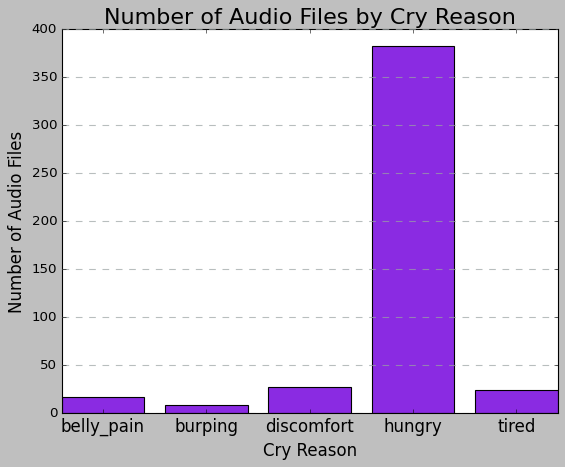

In [ ]:
count_by_type = pd.DataFrame(file_path_df.groupby(['audio_type']).size()).rename(columns={0: "count"})
count_by_type.reset_index(inplace=True)
plt.bar(count_by_type['audio_type'], count_by_type['count'],color = "blueviolet")
plt.grid(color='#9ba3a3', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.xlabel('Cry Reason', fontsize = 15)
plt.ylabel('Number of Audio Files', fontsize = 15)
plt.title('Number of Audio Files by Cry Reason', fontsize = 20)
plt.xticks(fontsize = 15)
plt.show()

**Observation:**
From the above graph it is clear that we have significantly higher number of audio files for cry reason 'hunger' than others. The other classes have more or else equal amount of data.

## IV. Feature Extraction and Dimentionality Reduction

**(1)** Framing:  For an audio file, the waveform is cut into segments with a duration of 1-second

**(2)** Feature Extraction

| Acoustic Feature | Definition | Number of Features Extracted per Frame |
| :-: |:-- | :-: |
| Mel-frequency cepstral coefficients (MFCC)| A set of features derived from log short-term power spectrum of a sound signal  on a nonlinear mel scale of frequency| 39 |
| Spectral Centroid| A number that represents the amplitude at the center of the spectrum of the signal distribution over a window calculated from the Fourier transform frequency.  $$
   Spectral\space Centroid = \frac{\sum\limits_{n=0}^{N-1} f(n)x(n)}{\sum\limits_{n=0}^{N-1} x(n)}
$$ <br> where x(n) is the weighted frequency value of nth bin, and f(n) is the center frequency of nth bin.| 1 |
| Spectral Flatness| A measure that quantifies how much a sound resembles a pure tone rather than noise <br> <br> $${{Spectral\space Flatness}}={\frac  {\exp \left({\frac  {1}{N}}\sum _{{n=0}}^{{N-1}}\ln x(n)\right)}{{\frac  {1}{N}}\sum _{{n=0}}^{{N-1}}x(n)}}$$ <br> where x(n) represents the magnitude of nth bin.| 1 |
| Spectral Contrast| The decibel difference between peaks and valleys in the spectrum| 7  |
| Spectral Rolloff| The frequency below which 85% of the magnitude distribution is concentrated | 1  |
| Chroma Features| A set of features represent the tonal content of a musical audio signal in a condensed form. | 12 |

**(3)** Flattening Features: Each 2-D acoustic feature is converted into 1-d vector before passing as input in the next process by flattening.

**(4)** Dimentionality Reduction and Standardization: We are using use standardization as our scaling method to have data centered around the mean with unit std. deviation in each column and we also do PCA for reducing some 1000+ features to key features that captures most of the information about the data.


In [ ]:
def processing_audio(audio_df = file_path_df.head(), n_second = 1):
    i = 0
    gender = []
    age = []
    cry_reason = []
    mfccs = []
    spectral_centriod = []
    spectral_flatness = []
    spectral_contrast = []
    spectral_rolloff = []
    chroma_features = []
    audio_index = []
    for f in audio_df["file_name"]:
        y, s = librosa.load(f)
        while len(y)>= s*n_second:
            gender.append(f.split("-")[-3])
            age.append(f.split("-")[-2])
            cry_reason.append(audio_df["audio_type"][i])
            # Start from dividing the sound signal into the form of frames with a duration of 1-seconds
            f1 = y[:s*n_second]
            y = y[s*n_second:]
            # Extract Mel-frequency cepstral coefficients (MFCCs) to represent the short-term power spectrum of sound.
            mfcc = librosa.feature.mfcc(y=f1, sr=s, n_mfcc=19)
            mfccs.append(mfcc)
            # Extract Spectral Centriod
            cent = librosa.feature.spectral_centroid(y=f1, sr=s)
            spectral_centriod.append(cent)
            # Extract Spectral flatness
            flat = librosa.feature.spectral_flatness(y=f1)
            spectral_flatness.append(flat)
            # Extract Spectral contrast
            S = np.abs(librosa.stft(f1))
            sc = librosa.feature.spectral_contrast(S=S, sr=s)
            spectral_contrast.append(sc)
            # Extract Spectral Rolloff
            rolloff = librosa.feature.spectral_rolloff(y=f1, sr=s)
            spectral_rolloff.append(rolloff)
            # Extract Chroma Features
            cf = librosa.feature.chroma_stft(y=f1, sr=s)
            chroma_features.append(cf)
            audio_index_current = f.split("/")[-1].split("-")[0]
            audio_index.append(int(audio_index_current))
        i += 1
    output_df = pd.DataFrame({"audio_index": audio_index,
                              "gender" : gender,
                              "age" : age,
                              "cry_reason" : cry_reason,
                              "mfcc" : mfccs,
                              "spectral_centroid": spectral_centriod,
                              "spectral_flatness": spectral_flatness,
                              "spectral_contrast": spectral_contrast,
                              "spectral_rolloff" : spectral_rolloff,
                              "chroma_features": chroma_features})
    return output_df

In [ ]:
def convert_matrix_vector_to_df(matrix_vector):
    # convert a vector of matrix to a vector of arrays by flattening all nested arrays
    flatten_df = matrix_vector.flatten()
    return flatten_df

In [ ]:
def convert_matrix_to_columns(data, column_name):
    # if the first cell of the column is a matrix then convert this column into multiple columns by flattening the matrix
    df = data[column_name].map(lambda x:convert_matrix_vector_to_df(x))
    temp_df = pd.DataFrame(df.tolist(),index = df.index)
    temp_df.columns = [column_name + f'{c}' for c in temp_df.columns]
    data = pd.concat([data,temp_df],axis =1)
    data = data.drop([column_name], axis=1)
    return data

In [ ]:
def feature_extraction(file_path_df):
    data_df = processing_audio(audio_df = file_path_df, n_second = 1)
    #2-D acoustic features are converted into 1-d vector before passing as input in the next process by flattening.
    flatten_data_df = data_df.copy()
    for column_name in data_df.columns:
        if type( data_df[column_name][0]) != str and not isinstance(data_df[column_name][0], (int, np.integer)) and (data_df[column_name][0].shape[0]*data_df[column_name][0].shape[1]>1):
            flatten_data_df = convert_matrix_to_columns(flatten_data_df, column_name)
    return data_df,flatten_data_df

In [ ]:
def derive_pc(X_train,X_test):
    # input: X matrix
    # output: principal components that explain at least 90% of the variance

    # Standardize X_train for classification
    X_train_standardized = StandardScaler().fit_transform(X_train)

     # Calculate the Eigenvectors and eigenvalues
    covariance_matrix = np.cov(X_train_standardized.T)
    eigen_values, eigen_vectors = eigh(covariance_matrix)

    # Calculate share of explained variance by number of features
    tot = sum(eigen_values)
    variance_explained = [(i/tot)*100 for i in sorted(eigen_values, reverse=True)]
    cum_variance_explained = np.cumsum(variance_explained)

    # Find the smallest number of features that explain at least 90% of the variance
    eigen_count = next(x for x, val in enumerate(cum_variance_explained)if val > 90) + 1

    # Calculate principal components
    pca = PCA(n_components= eigen_count)
    pca.fit(X_train_standardized)
    X_train_pc = pca.transform(X_train_standardized)

    # Sandardize and normalize X_test matrix
    X_test_standardized = StandardScaler().fit_transform(X_test)
    X_test_pc = pca.transform(X_test_standardized)

    return X_train_pc, X_test_pc


## V. Build Classifiers

#### Baseline Model

**Baseline Model** predicts the label with majority group in training data

In [ ]:
def baseline(X_train, X_test, y_train, y_test):
    # baseline predicts the cry reason with majority group in y_train
    stats = Counter(y_train)
    majority_group = max(stats, key=lambda key: stats[key])
    y_pred = [majority_group for i in range(y_test.shape[0])]
    return y_pred

#### Random Forest

**Random Forest (RF)**: RF combines the outputs of all decision trees (DT) to generate a single classification label.

For each DT:

(1) Draw a bootstrap sample of size N from training data

(2) Grow a RF tree with bootstrap sample by recursively repeat the steps below  at node until hyperparameter setting  is reached.

    Select a subset of variable at random
    Perform partition

Combine the output of all trees by taking the majority vote of classification prediction from all trees.


In [ ]:
def rf_pca(X_train, X_test, y_train, y_test):

    # Derive principal components of X_train and X_test
    X_train_pc, X_test_pc = derive_pc(X_train, X_test)

    # Set hyperparameters grid
    n_estimators = [100] # Number of trees in random forest
    max_features = [None]
    max_depth = [None] # Maximum number of levels in tree
    max_depth.append(None)
    min_samples_split = [2] # Minimum number of samples required to split a node
    min_samples_leaf = [1] # Minimum number of samples required at each leaf node
    bootstrap = [True] # Method of selecting samples for training each tree
    # Create the hyperparameter grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Set the base model
    rf_pca_model = RandomForestClassifier()
    # Find the hyperparameter combination that returns the best result
    rf_pca_model_optimal = GridSearchCV(estimator = rf_pca_model,
                                        param_grid = random_grid,
                                        cv = 2,# 2-fold cross validation,
                                        verbose=2,# the computation time for each fold, parameter candidate, and the score are displayed
                                        n_jobs = -1) #using all processor

    rf_pca_model_optimal.fit(X_train_pc, y_train)

    y_pred = rf_pca_model_optimal.predict(X_test_pc)

    return y_pred

#### Balanced Random Forest (BRF)

An BRF classifier randomly under-samples each boostrap sample to balance it. In other words, BRF iteratively draw a bootstrap sample with equal proportions of data points from both the minority and the majority class.

In [ ]:
def brf_pca(X_train, X_test, y_train, y_test):

    # Derive principal components of X_train and X_test
    X_train_pc, X_test_pc = derive_pc(X_train, X_test)

    # Build random forest model
    rf_pca_model = BalancedRandomForestClassifier(n_estimators = 100)
    rf_pca_model = rf_pca_model.fit(X_train_pc,y_train)

    y_pred = rf_pca_model.predict(X_test_pc)
    return y_pred

#### Random Forest - SMOTE (Synthetic Minority Oversampling Technique)

SMOTE works by generating instances that are close in feature space, using interpolation between positive cases that are close to each other. It randomly selects a minority class instance and finds its nearest neighbour. `

In [ ]:
def rf_smote(X_train, X_test, y_train, y_test):

    #Use SMOTE to oversample the minority class
    oversample = SMOTE()
    over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)
    # Build random forest model
    SMOTE_SRF = RandomForestClassifier(n_estimators=100, random_state=0)
    # Model fitting with data with smote data
    SMOTE_SRF.fit(over_X_train, over_y_train)
    y_pred = SMOTE_SRF.predict(X_test)
    return y_pred

#### Random Forest with Feature Selected with Null Importance Score

In [ ]:
def get_rf_importances(X, y, shuffle, rf_params=None):
  # calculate the importance of features
  # output is a dataframe that includes the feature names and associated Gini importance.
  if rf_params is None:
    rf_params = dict()
  rf_params['oob_score'] = True
  y_new = y.copy()
  if shuffle:
    y_new = y_new.sample(frac = 1.0)

  clf = RandomForestClassifier(**rf_params)
  clf.fit(X, y_new)

  imp_df = pd.DataFrame({
      'feature': clf.feature_names_in_,
      'importance': clf.feature_importances_,
      'train_oob_score': clf.oob_score_,
  })
  return imp_df.sort_values(by=['importance'], ascending=False).reset_index(drop=True)

def get_null_imp_distribs(X, y, n_bench=1, n_null=50, rf_params=None):
  ### importance of the real label distribution
  real_imp = []
  for i in range(n_bench):
    curr_imp = get_rf_importances(X, y, shuffle=False, rf_params=rf_params)
    curr_imp['iter'] = i
    real_imp.append(curr_imp)
  real_imp = pd.concat(real_imp, axis=0, ignore_index=True)

  ### importance of the null label distribution
  null_imp = []
  for i in tqdm(range(n_null)):
    curr_imp = get_rf_importances(X, y, shuffle=True, rf_params=rf_params)
    curr_imp['iter'] = i
    null_imp.append(curr_imp)
  null_imp = pd.concat(null_imp, axis=0, ignore_index=True)
  ### calculate feature score based on the distribution of null importances and the value of real importance
  mean_real_imp = real_imp.groupby('feature')['importance'].median().to_frame('real_importance').reset_index()
  tmp_score_df = null_imp.merge(mean_real_imp, on=['feature'], how='left')
  tmp_score_df['is_real_better'] = tmp_score_df['real_importance'] > tmp_score_df['importance']
  score_df = tmp_score_df.groupby('feature')['is_real_better'].sum().to_frame('C').reset_index()
  score_df['score'] = (score_df['C'] - n_null/2)/np.sqrt(n_null/4)
  score_df = score_df.sort_values(by=['score'], ascending=False).reset_index(drop=True)
  return real_imp, null_imp, score_df

In [ ]:
def show_null_distribs(real_imp, null_imp, feature_list):
  # This function is defined for data visualization
  n = len(feature_list)
  ncols = 2
  nrows = (n-1)//ncols + 1
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5*nrows))
  for i, feat in enumerate(feature_list):
    fig_row = i//ncols
    fig_col = i - fig_row*ncols
    ax = axes[fig_row][fig_col]
    fig.patch.set_facecolor('white')
    p = ax.hist(null_imp.loc[null_imp['feature']==feat, 'importance'].values,
                label='null importances',color="skyblue", edgecolor= "skyblue")
    ax.vlines(x=real_imp.loc[real_imp['feature']==feat, 'importance'].mean(),
             ymin=0, ymax=np.max(p[0]),
              color='coral',
              linewidth=8,
              label='real importance')

    # ax.legend()
    ax.set_title(feat, fontsize = 20)

In [ ]:
def rf_feature_selection(X_train, X_test, y_train, y_test):
  # This random forest tree select the top 400 features based on the score calculated from null importance and real importance
  # return the predicted label of the test observations
  rf_params = None
  real_imp, null_imp, imp_score = get_null_imp_distribs(X_train, y_train, n_null=50, rf_params=rf_params)
  selected_features = imp_score['feature'].iloc[:400].to_list()
  X_train_selected = X_train[[x for x in selected_features]]
  X_test_selected = X_test[[x for x in selected_features]]
  rf_model = RandomForestClassifier(n_estimators = 150)
  rf_model = rf_model.fit(X_train_selected,y_train)
  y_pred = rf_model.predict(X_test_selected)
  return y_pred


#### Vision Transformer

In [ ]:
# set up image loading path
images_paths = os.listdir(project_path +"image_segments")

In [ ]:
label_map = {
    'hungry': 0,
    'tired':1,
    'burping':2,
    'belly_pain':3,
    'discomfort': 4
}

In [ ]:
def build_VIT(X_train,augmentation_setting =0):
    inputs = Input(shape=X_train.shape[1:])
    if augmentation_setting == 0:
      # Augment input data
      augmented_data = keras.Sequential([layers.Resizing(72, 72), # fix image size to 72 * 72
                                        layers.Normalization(),
                                        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
                                        ],)(inputs)
    elif augmentation_setting ==1:
      augmented_data = keras.Sequential([layers.Resizing(72, 72),],)(inputs)
    else:
      augmented_data = keras.Sequential([layers.Resizing(72, 72), # fix image size to 72 * 72
                                        layers.Normalization(),],)(inputs)
    # Create and flatten patches
    batch_size = tf.shape(augmented_data)[0]
    patch_parameters = [1,patch_size, patch_size, 1]

    # Extract patches from augmented images and reshape patches
    patches = tf.image.extract_patches(images = augmented_data,sizes = patch_parameters,strides = patch_parameters,rates = [1,1,1,1],padding = "VALID",)
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])

    # Encode patches: projection and embedding
    projection_dimension = 16
    num_patches = int((72/patch_size)**2)
    p = tf.range(0, num_patches, 1)
    encoded_patches = Dense(units=projection_dimension,
                            activation = 'relu',)(patches)  + Embedding(input_dim=num_patches,
                                                                        output_dim = projection_dimension)(p)
    # Build Transformer Encoder
    for _ in range(4): # Tranformers contains 4 identical blocks.
        # multi-head attention
        layer_1 = LayerNormalization(epsilon=0.0001)(encoded_patches)
        attention = MHA(4, projection_dimension, dropout=0.1)(layer_1, layer_1)

        # Norm and add
        layer_2 = layers.Add()([attention, encoded_patches])
        layer_3 = LayerNormalization(epsilon=0.0001)(layer_2)
        encoded_patches_2 = layers.Add()([layer_2, layer_3])

        # Multi-Head Attention + Encoded Patches + Normalization
        layer_4 = Dense(units = projection_dimension, activation = 'relu',)(encoded_patches_2)
        layer_5 = layers.Add()([layer_4, layer_4])
        layer_6 = LayerNormalization(epsilon=0.0001)(layer_5)
        layer_7 = layers.Add()([layer_5, encoded_patches_2])
        f_patches = layers.Add()([layer_6,layer_7])

    # Normalization and Multilayer perception with softmax activation
    features = LayerNormalization(epsilon=0.0001)(f_patches)
    features = Flatten()(features)
    features = Dropout(0.1)(features)
    output = Sequential([Dense(projection_dimension),Activation('tanh'),Dropout(0.5),Dense(5),Activation('softmax'),])(features)
    vit_model = keras.Model(inputs=inputs, outputs=output)
    return vit_model

The following block defines the class weight.

$$Weight (x) = max\{1, log(\frac{N}{n(x))}\}$$.

where N is the number of instances in training set.

n(x) is the number of label x in training set

In [ ]:
def create_class_weight(count_dict):
    total = len(y_train)
    keys = count_dict.keys()
    class_weight = dict()
    for key in keys:
      weight = math.log(total/float(count_dict[key]))
      if weight > 1:
        class_weight[key] = weight
      else:
        class_weight[key] = 1
    return class_weight

In [ ]:
def vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 0):
   # this function takes the inputs: model, X_test, hyperparameters for Adam optimizer, and class weight options
   # returns predicted_label for test observation, real labels of test obersavations, and history
   # The class_weight_settings are 0, 1, 2:
   # 0 represents equal weight
   # 1 represents the weight defined in the block above
   # 2 represents the inverse proportional weight, which equals to the total count of test observations divided by count of each label
    batch_size = 256
    vit_model.compile(
        optimizer = AdamW(learning_rate=lr, weight_decay= wd),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = [
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )

    callback_cp = keras.callbacks.ModelCheckpoint(filepath = "/temp_f12",
                                                  monitor="val_accuracy",
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  verbose =1 )
    if class_weight_setting == 1:
      classes, counts = np.unique(y_train, return_counts = True)
      count_dict = {k:c for k, c in zip(classes, counts)}
      class_weight = create_class_weight(count_dict)
      history = vit_model.fit(x = X_train,y = y_train,batch_size=batch_size, epochs=num_epochs,verbose = 'auto',
                              callbacks=[callback_cp],validation_split=0.2, shuffle=True,class_weight = class_weight)
    elif class_weight_setting == 2:
      classes, counts = np.unique(y_train, return_counts = True)
      N = len(y_train)
      class_weight = {k: (N/c) for k, c in zip(classes, counts)}
      history = vit_model.fit(x = X_train,y = y_train,batch_size=batch_size, epochs=num_epochs,verbose = 'auto',
                              callbacks=[callback_cp],validation_split=0.2, shuffle=True,class_weight = class_weight)
    else:
      history = vit_model.fit(x = X_train,y = y_train,batch_size=batch_size, epochs=num_epochs,verbose = 'auto',callbacks=[callback_cp],
                              validation_split=0.2, shuffle=True)

    vit_model.load_weights("/temp_f12")
    y_prob = vit_model.predict(X_test)
    y_pred_index = y_prob.argmax(axis=-1)
    label_map_reverse = {
        0:'hungry',
        1:'tired',
        2: 'burping',
        3: 'belly_pain',
        4: 'discomfort'}

    y_pred = [label_map_reverse[i] for i in y_pred_index]
    y_test_label = [label_map_reverse[i] for i in y_test.reshape(-1)]

    return y_pred, y_test_label,history


## VII. Report Performance

In [ ]:
# Define function for reporting performance metrics

def report_performance(test_df,y_pred):
    # input: test data that contains both real label of cry reason and all features
    # output: a dictionary with metric names as keys.

    # calculate the number of audios by cry reason
    test_count = test_df.groupby(['cry_reason']).size()
    reason_dict = test_count.to_dict()

    # build a function that only keeps the most frequent cry reason from an array
    def parse_pred(entry):
        if isinstance(entry, str):
            return entry
        return max(entry, key=lambda x: reason_dict[x])
    pred_dict = {'audio_index': test_df['audio_index'], 'y_test': test_df['cry_reason'], 'y_pred': y_pred}
    temp_df = pd.DataFrame(pred_dict)

    # predict the entire audio's cry reason based on the majority group of predicted labels of its cuts
    temp_result = temp_df.groupby(['audio_index'])[['y_test','y_pred']].agg(pd.Series.mode)
    temp_result['y_pred'] = temp_result['y_pred'].map(parse_pred)

    # calculate precision, recall, and f1 based on the cry reason of orginal audio and predictions
    precision_1, recall_1,f1_1, null_value_1 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'],
                                                                               average='macro',
                                                                               zero_division=0)

    precision_2, recall_2,f1_2, null_value_2 = precision_recall_fscore_support(temp_result['y_test'],
                                                                               temp_result['y_pred'],
                                                                               average='weighted',
                                                                               zero_division=0)
    # calucate accuracy rate

    accuracy = accuracy_score(temp_result['y_test'],temp_result['y_pred'])
    return {
        'precision_macro': precision_1,
        'recall_macro': recall_1,
        'f1_macro': f1_1,
        'precision_weighted': precision_2,
        'recall_weighted': recall_2,
        'f1_weighted': f1_2,
        'accuracy': accuracy
    }

In [ ]:
def report_performance_vit(y_pred,y_test_label):
    # calculate precision, recall, and f1 based on the cry reason of orginal audio and predictions
    precision_1, recall_1,f1_1, null_value_1 = precision_recall_fscore_support(y_test_label,y_pred,
                                                                               average='macro',
                                                                               zero_division=0)

    precision_2, recall_2,f1_2, null_value_2 = precision_recall_fscore_support(y_test_label,y_pred,
                                                                               average='weighted',
                                                                               zero_division=0)
    # calucate accuracy rate

    accuracy = accuracy_score(y_test_label,y_pred,)
    return {
        'precision_macro': precision_1,
        'recall_macro': recall_1,
        'f1_macro': f1_1,
        'precision_weighted': precision_2,
        'recall_weighted': recall_2,
        'f1_weighted': f1_2,
        'accuracy': accuracy
    }

In [ ]:
### Run all models with K-fold cross validation

In [ ]:
### Feature Extraction
data_df, flatten_data_df = feature_extraction(file_path_df)

In [ ]:
def extract_index(file_path):
    # extract information on age in month from file name
    a = int(file_path.split("/")[-1].split("-")[0])
    return a

In [ ]:
file_path_df["audio_index"] = file_path_df["file_name"].map(lambda x:extract_index(x))

In [ ]:
x_index_list = list(file_path_df["audio_index"])
y_cry_reason = file_path_df['audio_type']

In [ ]:
# Read the Mel Spectrograms from Audio Files
X = []
y = []
i = 0
for image_path in images_paths:
    i += 1
    if i%100 == 0:
      print(i)
    image = Image.open(project_path+'/image_segments/' + image_path).convert('RGB')
    image_array = np.array(image)
    image_array = image_array / 255
    label = image_path.split(',')[0]
    X.append(image_array)
    y.append(label_map[label])
X = np.array(X)
y = np.array(y).reshape(-1, 1)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200


In [ ]:
X_train_index,X_test_index,_,_ = train_test_split(x_index_list,
                                                  y_cry_reason,
                                                  test_size=0.25,
                                                  stratify=y_cry_reason,
                                                  shuffle=True,
                                                  random_state=100)

In [ ]:
# Run Random Forest Models and Baseline
models = ['baseline(X_train, X_test, y_train, y_test)',
          'rf_pca(X_train, X_test, y_train, y_test)',
          'brf_pca(X_train, X_test, y_train, y_test)',
          'rf_feature_selection(X_train, X_test, y_train, y_test)',
          'rf_smote(X_train, X_test, y_train, y_test)']
for i, model in enumerate(models):
  train_df = flatten_data_df[flatten_data_df['audio_index'].isin(X_train_index)]
  test_df = flatten_data_df[flatten_data_df['audio_index'].isin(X_test_index)]
  col = ['audio_index','cry_reason','gender','k_fold_index']
  X_train = train_df[[x for x in train_df.columns if x not in col]]
  y_train = train_df['cry_reason']
  X_test = test_df[[x for x in test_df.columns if x not in col]]
  y_test = test_df['cry_reason']
  y_pred = eval(model)
  metrics_dict = report_performance(test_df,y_pred)
  if i == 0:
    metrics_df = pd.Series(metrics_dict).to_frame().T
    metrics_df['model_name'] = model.split('(')[0]
  else:
    temp_df = pd.Series(metrics_dict).to_frame().T
    temp_df['model_name'] = model.split('(')[0]
    metrics_df = pd.concat([metrics_df, temp_df],axis = 0)

metrics_df

In [ ]:
#file back-up
metrics_df.to_csv(dic_path +"/gdrive/MyDrive/DS5500Jing/metrics_df_RF.csv")

In [ ]:
# Train Test split for Vision Transformer.
# Same audios are used as test set in Random Forest experiment and Vision Transformer experiment

In [ ]:
image_segment_audio_index = pd.DataFrame(images_paths)[0].apply(lambda x: x.split(',')[1])
image_segment_audio_index = image_segment_audio_index.apply(lambda x: x.split('_')[1]).astype(int)

In [ ]:
X_train = X[image_segment_audio_index.isin(X_train_index)]
y_train = y[image_segment_audio_index.isin(X_train_index)]
X_test = X[image_segment_audio_index.isin(X_test_index)]
y_test = y[image_segment_audio_index.isin(X_test_index)]

In [ ]:
# run the model with different settings for class weight
patch_size = 6
num_epochs = 80
#Each group has same weight
vit_model = build_VIT(X_train,augmentation_setting =0)
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 0 )
metrics_dict = report_performance_vit(y_pred,y_test_label)
metrics_df = pd.Series(metrics_dict).to_frame().T
metrics_df['model_name'] = 'VIT_equal_weight'

# Use max between 1 and log(N/n(x)) where n is the total number of training obersavations and n(x) is the frequncy of the label in train set
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 1)
metrics_dict = report_performance_vit(y_pred,y_test_label)
temp_df = pd.Series(metrics_dict).to_frame().T
temp_df['model_name'] = 'VIT_log_weight'
metrics_df = pd.concat([metrics_df, temp_df],axis = 0)

#Adjust class weight inversely propotional to the class frequency
vit_model = build_VIT(X_train,augmentation_setting =0)
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 2)
metrics_dict = report_performance_vit(y_pred,y_test_label)
temp_df = pd.Series(metrics_dict).to_frame().T
temp_df['model_name'] = 'VIT_inverse_proportional_weight'
metrics_df = pd.concat([metrics_df, temp_df],axis = 0)


Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/8 [=========================>....] - ETA: 0s - loss: 1.2392 - accuracy: 0.5820
Epoch 1: val_accuracy improved from -inf to 0.62551, saving model to /temp_f12
8/8 [==============================] - 8s 285ms/step - loss: 1.2339 - accuracy: 0.5908 - val_loss: 1.3709 - val_accuracy: 0.6255
Epoch 2/80
7/8 [=========================>....] - ETA: 0s - loss: 1.0431 - accuracy: 0.7388
Epoch 2: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 97ms/step - loss: 1.0300 - accuracy: 0.7427 - val_loss: 1.4985 - val_accuracy: 0.6255
Epoch 3/80
7/8 [=========================>....] - ETA: 0s - loss: 0.9969 - accuracy: 0.7360
Epoch 3: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 93ms/step - loss: 0.9887 - accuracy: 0.7365 - val_loss: 1.5101 - val_accuracy: 0.6255
Epoch 4/80
8/8 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.6994
Epoch 4: val_accuracy did not improve from 0.62551
8/8 [=====================

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/8 [=========================>....] - ETA: 0s - loss: 2.0903 - accuracy: 0.6401
Epoch 1: val_accuracy improved from -inf to 0.51235, saving model to /temp_f12
8/8 [==============================] - 4s 245ms/step - loss: 2.1071 - accuracy: 0.6264 - val_loss: 1.6117 - val_accuracy: 0.5123
Epoch 2/80
7/8 [=========================>....] - ETA: 0s - loss: 2.0417 - accuracy: 0.5179
Epoch 2: val_accuracy improved from 0.51235 to 0.62551, saving model to /temp_f12
8/8 [==============================] - 1s 105ms/step - loss: 2.0079 - accuracy: 0.5280 - val_loss: 1.4823 - val_accuracy: 0.6255
Epoch 3/80
7/8 [=========================>....] - ETA: 0s - loss: 2.0456 - accuracy: 0.6004
Epoch 3: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 92ms/step - loss: 2.0097 - accuracy: 0.6063 - val_loss: 1.4383 - val_accuracy: 0.6255
Epoch 4/80
7/8 [=========================>....] - ETA: 0s - loss: 1.9593 - accuracy: 0.5915
Epoch 4: val_accuracy did not improve from 0.

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/8 [=========================>....] - ETA: 0s - loss: 7.8602 - accuracy: 0.2104
Epoch 1: val_accuracy improved from -inf to 0.00206, saving model to /temp_f12
8/8 [==============================] - 4s 267ms/step - loss: 7.8199 - accuracy: 0.2059 - val_loss: 2.6103 - val_accuracy: 0.0021
Epoch 2/80
7/8 [=========================>....] - ETA: 0s - loss: 7.5742 - accuracy: 0.2026
Epoch 2: val_accuracy improved from 0.00206 to 0.48560, saving model to /temp_f12
8/8 [==============================] - 1s 106ms/step - loss: 7.5320 - accuracy: 0.2054 - val_loss: 2.1227 - val_accuracy: 0.4856
Epoch 3/80
7/8 [=========================>....] - ETA: 0s - loss: 7.4644 - accuracy: 0.2790
Epoch 3: val_accuracy did not improve from 0.48560
8/8 [==============================] - 1s 98ms/step - loss: 7.3091 - accuracy: 0.2831 - val_loss: 2.3555 - val_accuracy: 0.2737
Epoch 4/80
7/8 [=========================>....] - ETA: 0s - loss: 7.5945 - accuracy: 0.2193
Epoch 4: val_accuracy did not improve from 0.

In [ ]:
metrics_df

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy,model_name
0,0.152174,0.200000,0.172840,0.578922,0.760870,0.657542,0.760870,VIT_equal_weight
0,0.152058,0.199365,0.172527,0.578482,0.758454,0.656355,0.758454,VIT_log_weight
0,0.173653,0.199064,0.176874,0.581563,0.609903,0.592757,0.609903,VIT_inverse_proportional_weight


In [ ]:
#file back-up
metrics_df.to_csv(dic_path +"/gdrive/MyDrive/DS5500Jing/metrics_df_vit1.csv")

In [ ]:
# patch size 4 and 8
patch_size = 4
num_epochs = 80
vit_model = build_VIT(X_train,augmentation_setting =0)
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 0 )
metrics_dict = report_performance_vit(y_pred,y_test_label)
metrics_df = pd.Series(metrics_dict).to_frame().T
metrics_df['model_name'] = 'VIT_patch_size 4'

patch_size = 8
vit_model = build_VIT(X_train,augmentation_setting =0)
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 0)
metrics_dict = report_performance_vit(y_pred,y_test_label)
temp_df = pd.Series(metrics_dict).to_frame().T
temp_df['model_name'] = 'VIT_patch_size 8'
metrics_df = pd.concat([metrics_df, temp_df],axis = 0)


Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - ETA: 0s - loss: 2.0050 - accuracy: 0.3165
Epoch 1: val_accuracy improved from -inf to 0.62551, saving model to /temp_f12
8/8 [==============================] - 4s 241ms/step - loss: 2.0050 - accuracy: 0.3165 - val_loss: 1.4926 - val_accuracy: 0.6255
Epoch 2/80
8/8 [==============================] - ETA: 0s - loss: 0.9909 - accuracy: 0.7627
Epoch 2: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 105ms/step - loss: 0.9909 - accuracy: 0.7627 - val_loss: 1.6580 - val_accuracy: 0.6255
Epoch 3/80
8/8 [==============================] - ETA: 0s - loss: 0.9754 - accuracy: 0.7576
Epoch 3: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 105ms/step - loss: 0.9754 - accuracy: 0.7576 - val_loss: 1.5992 - val_accuracy: 0.6255
Epoch 4/80
8/8 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.7344
Epoch 4: val_accuracy did not improve from 0.62551
8/8 [===================

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/8 [=========================>....] - ETA: 0s - loss: 1.1891 - accuracy: 0.5792
Epoch 1: val_accuracy improved from -inf to 0.62551, saving model to /temp_f12
8/8 [==============================] - 3s 225ms/step - loss: 1.1663 - accuracy: 0.5898 - val_loss: 1.6894 - val_accuracy: 0.6255
Epoch 2/80
7/8 [=========================>....] - ETA: 0s - loss: 0.9628 - accuracy: 0.7327
Epoch 2: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 93ms/step - loss: 0.9665 - accuracy: 0.7339 - val_loss: 1.8742 - val_accuracy: 0.6255
Epoch 3/80
8/8 [==============================] - ETA: 0s - loss: 0.9592 - accuracy: 0.7468
Epoch 3: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 93ms/step - loss: 0.9592 - accuracy: 0.7468 - val_loss: 1.9322 - val_accuracy: 0.6255
Epoch 4/80
7/8 [=========================>....] - ETA: 0s - loss: 0.9123 - accuracy: 0.7483
Epoch 4: val_accuracy did not improve from 0.62551
8/8 [=====================

In [ ]:
metrics_df

,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,accuracy,model_name
0,0.152174,0.2,0.17284,0.578922,0.76087,0.657542,0.76087,VIT_patch_size 4
0,0.152174,0.2,0.17284,0.578922,0.76087,0.657542,0.76087,VIT_patch_size 8


In [ ]:
#file back-up
metrics_df.to_csv(dic_path +"/gdrive/MyDrive/DS5500Jing/metrics_df_vit2.csv")

In [ ]:
patch_size = 6
num_epochs = 80
vit_model = build_VIT(X_train,augmentation_setting =0)
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 0 )
metrics_dict = report_performance_vit(y_pred,y_test_label)
metrics_df = pd.Series(metrics_dict).to_frame().T
metrics_df['model_name'] = 'VIT_with_augmentation'

vit_model = build_VIT(X_train,augmentation_setting =1)
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 0)
metrics_dict = report_performance_vit(y_pred,y_test_label)
temp_df = pd.Series(metrics_dict).to_frame().T
temp_df['model_name'] = 'VIT_without_augmentation'
metrics_df = pd.concat([metrics_df, temp_df],axis = 0)

vit_model = build_VIT(X_train,augmentation_setting =2)
y_pred, y_test_label,history = vit(vit_model,X_test,lr = 0.0001, wd = 0.0001,class_weight_setting = 0 )
metrics_dict = report_performance_vit(y_pred,y_test_label)
temp_df = pd.Series(metrics_dict).to_frame().T
temp_df['model_name'] = 'VIT_with_normalization'
metrics_df = pd.concat([metrics_df, temp_df],axis = 0)

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/8 [=========================>....] - ETA: 0s - loss: 1.2907 - accuracy: 0.4911
Epoch 1: val_accuracy improved from -inf to 0.62551, saving model to /temp_f12
8/8 [==============================] - 3s 233ms/step - loss: 1.2740 - accuracy: 0.5033 - val_loss: 1.5991 - val_accuracy: 0.6255
Epoch 2/80
7/8 [=========================>....] - ETA: 0s - loss: 0.9422 - accuracy: 0.7467
Epoch 2: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 93ms/step - loss: 0.9471 - accuracy: 0.7483 - val_loss: 1.8327 - val_accuracy: 0.6255
Epoch 3/80
7/8 [=========================>....] - ETA: 0s - loss: 0.9844 - accuracy: 0.7746
Epoch 3: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 97ms/step - loss: 0.9844 - accuracy: 0.7725 - val_loss: 1.9102 - val_accuracy: 0.6255
Epoch 4/80
7/8 [=========================>....] - ETA: 0s - loss: 0.9669 - accuracy: 0.7679
Epoch 4: val_accuracy did not improve from 0.62551
8/8 [=====================

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/8 [=========================>....] - ETA: 0s - loss: 2.7306 - accuracy: 0.0915
Epoch 1: val_accuracy improved from -inf to 0.32510, saving model to /temp_f12
8/8 [==============================] - 3s 228ms/step - loss: 2.6650 - accuracy: 0.0973 - val_loss: 1.4084 - val_accuracy: 0.3251
Epoch 2/80
7/8 [=========================>....] - ETA: 0s - loss: 1.4864 - accuracy: 0.4157
Epoch 2: val_accuracy improved from 0.32510 to 0.62551, saving model to /temp_f12
8/8 [==============================] - 1s 99ms/step - loss: 1.4757 - accuracy: 0.4292 - val_loss: 1.0343 - val_accuracy: 0.6255
Epoch 3/80
7/8 [=========================>....] - ETA: 0s - loss: 1.2129 - accuracy: 0.6378
Epoch 3: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 90ms/step - loss: 1.1943 - accuracy: 0.6454 - val_loss: 1.1405 - val_accuracy: 0.6255
Epoch 4/80
7/8 [=========================>....] - ETA: 0s - loss: 1.0900 - accuracy: 0.7048
Epoch 4: val_accuracy did not improve from 0.6

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/8 [=========================>....] - ETA: 0s - loss: 1.3708 - accuracy: 0.5050
Epoch 1: val_accuracy improved from -inf to 0.62551, saving model to /temp_f12
8/8 [==============================] - 3s 255ms/step - loss: 1.3481 - accuracy: 0.5198 - val_loss: 1.2249 - val_accuracy: 0.6255
Epoch 2/80
7/8 [=========================>....] - ETA: 0s - loss: 1.0583 - accuracy: 0.6735
Epoch 2: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 97ms/step - loss: 1.0461 - accuracy: 0.6752 - val_loss: 1.5021 - val_accuracy: 0.6255
Epoch 3/80
8/8 [==============================] - ETA: 0s - loss: 0.9996 - accuracy: 0.7097
Epoch 3: val_accuracy did not improve from 0.62551
8/8 [==============================] - 1s 97ms/step - loss: 0.9996 - accuracy: 0.7097 - val_loss: 1.6128 - val_accuracy: 0.6255
Epoch 4/80
7/8 [=========================>....] - ETA: 0s - loss: 0.9919 - accuracy: 0.7271
Epoch 4: val_accuracy did not improve from 0.62551
8/8 [=====================

In [ ]:
#file back-up
metrics_df.to_csv(dic_path +"/gdrive/MyDrive/DS5500Jing/metrics_df_vit3.csv")

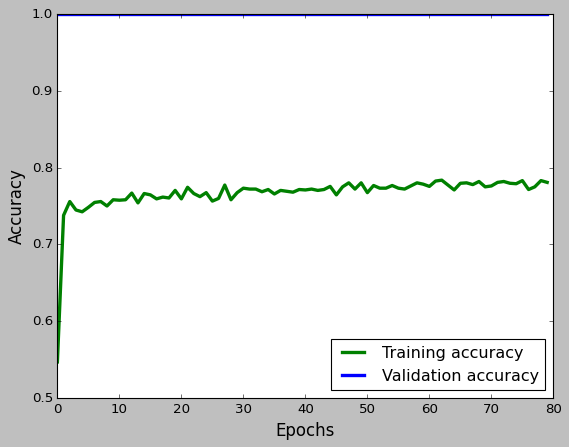

In [ ]:
# Training and Validation Accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(num_epochs)
plt.plot(epochs, loss_train, 'g', label='Training accuracy', linewidth = 3)
plt.plot(epochs, loss_val, 'b', label='Validation accuracy', linewidth = 3)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.legend(loc='lower right')
plt.show()

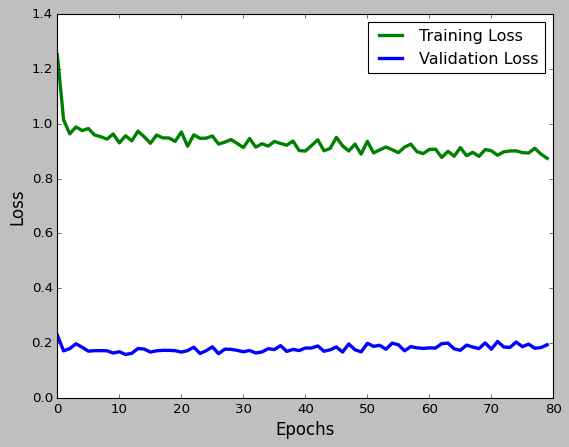

In [ ]:
# Training and Validation Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(num_epochs)
plt.plot(epochs, loss_train, 'g', label='Training Loss', linewidth = 3)
plt.plot(epochs, loss_val, 'b', label='Validation Loss', linewidth = 3)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.show()

Text(0.5, 0, 'score')

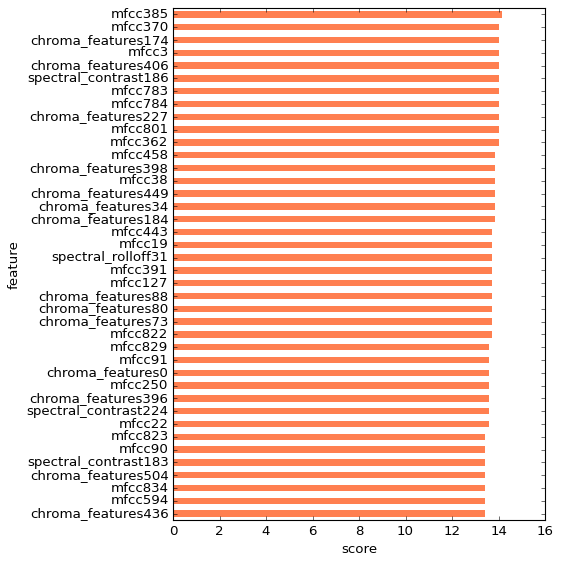

In [ ]:
# The following code creates a bar graph of features based on their calculate importance score
show_top = 40
cmap = matplotlib.colormaps['gist_rainbow']
colors = cmap(np.linspace(0,1,show_top))
fig, ax = plt.subplots(figsize=(6, 8))
fig.patch.set_facecolor('white')
imp_score[['feature', 'score']].iloc[:show_top].set_index('feature').plot(ax=ax, kind='barh', legend=False, edgecolor='None',
                                                                          color=
                                                                          'coral')
plt.gca().invert_yaxis()
plt.xlabel('score')

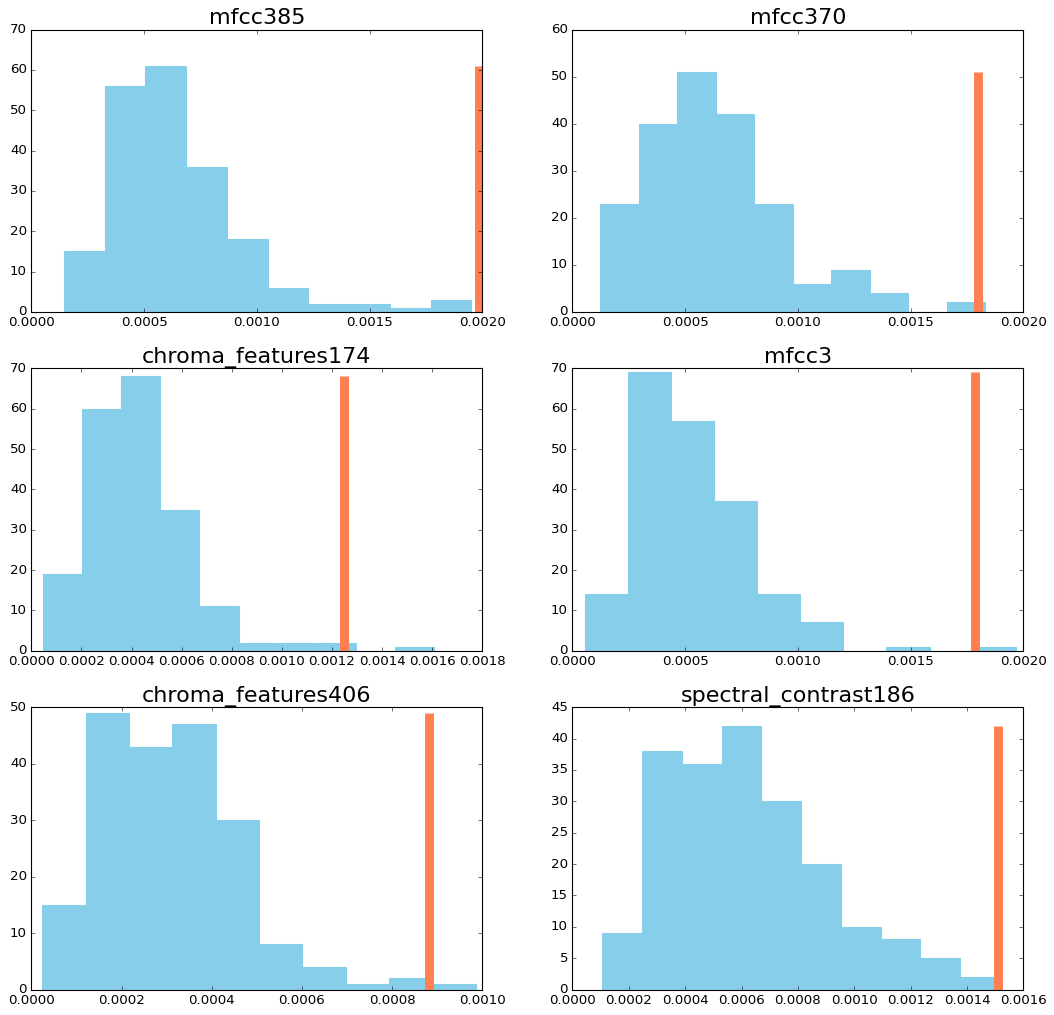

In [ ]:
# Show the distribution of null importance and real importance of good features
best_features = imp_score['feature'].iloc[:6].to_list()
worst_features = imp_score['feature'].iloc[-366:-360].to_list()
show_null_distribs(real_imp, null_imp, best_features)

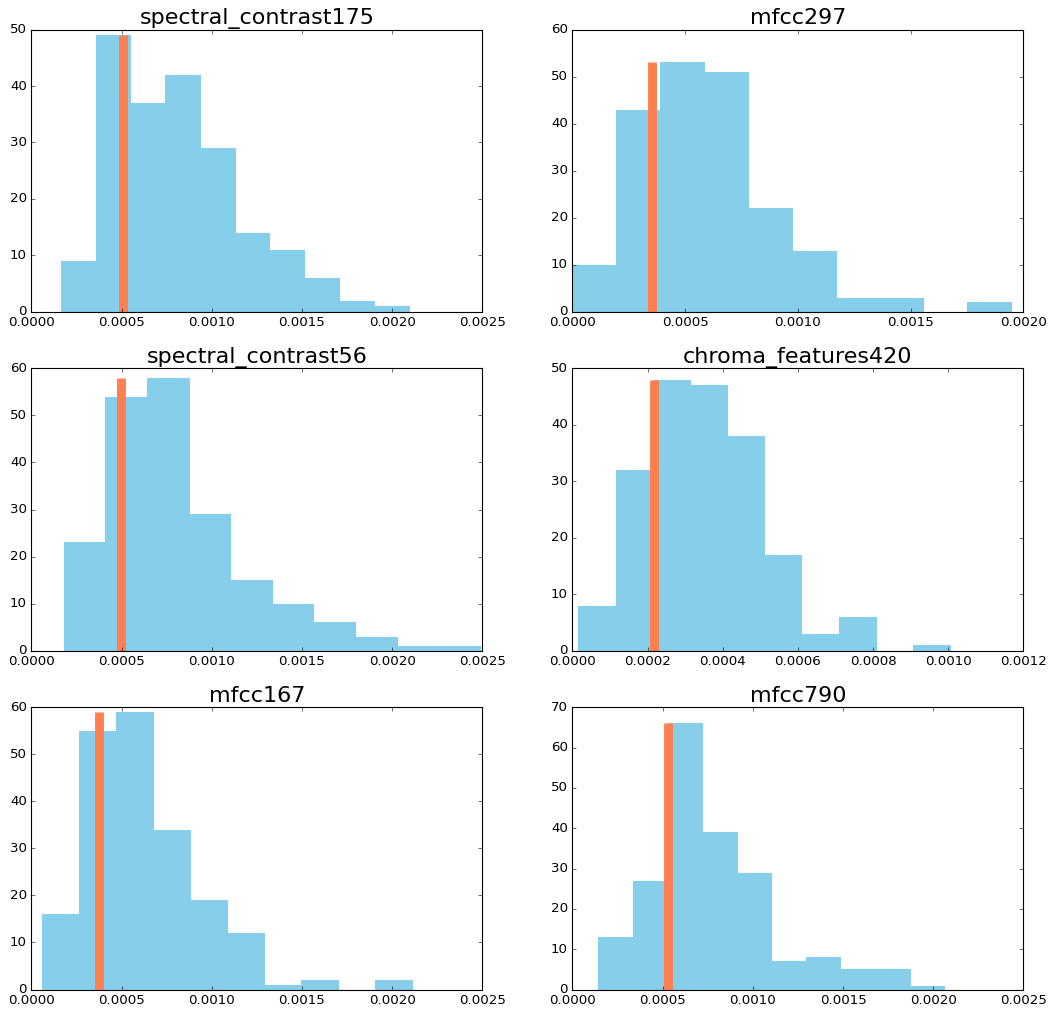

In [ ]:
# Show the distribution of null importance and real importance of bad features
show_null_distribs(real_imp, null_imp, worst_features)